<a id="top"></a>
### **Script replicating the figures and analysis in _Characterising spatial structure in climate model ensembles_**

EPP analysis of an unstructured ensemble, illustrated using the UKCP18 regional PPE:
- [**Figure 1:** Change in frequency of wet days in UKCP18 ensemble members between 1980-2010 and 2050-2079](#figure-1)
- [**Section 3:** Simple EPP analysis](#simple-epps)

EPP analysis of an unbalanced hierarchical ensemble, illustrated using the EuroCORDEX regional MME:
- [(i) Estimate the GCM and RCM effects](#fitted-model2)
- [**Figure 3:** Estimated partitioning of uncertainty](#estimated-anova)
- [**Figure 4:** EPP analysis of estimated GCM effects](#gcm-epps)


In [16]:
# all modules & methods are provided in the epp_manova script
from epp_manova import *

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Switch local working directory
import os
os.chdir("/data/met/reports/epp-paper/binder")

---
### **Analysis of an unstructured ensemble**

<a id="figure-1"></a>
#### **Figure 1: change in frequency of wet days in UKCP18 ensemble members between 1980-2010 and 2050-2079** [^](#top)

Text(0.5, 1.0, 'Figure 1: Changes in percentage of wet summer days in the UKCP18 ensemble members between 1981-2010 and 2050-2079')

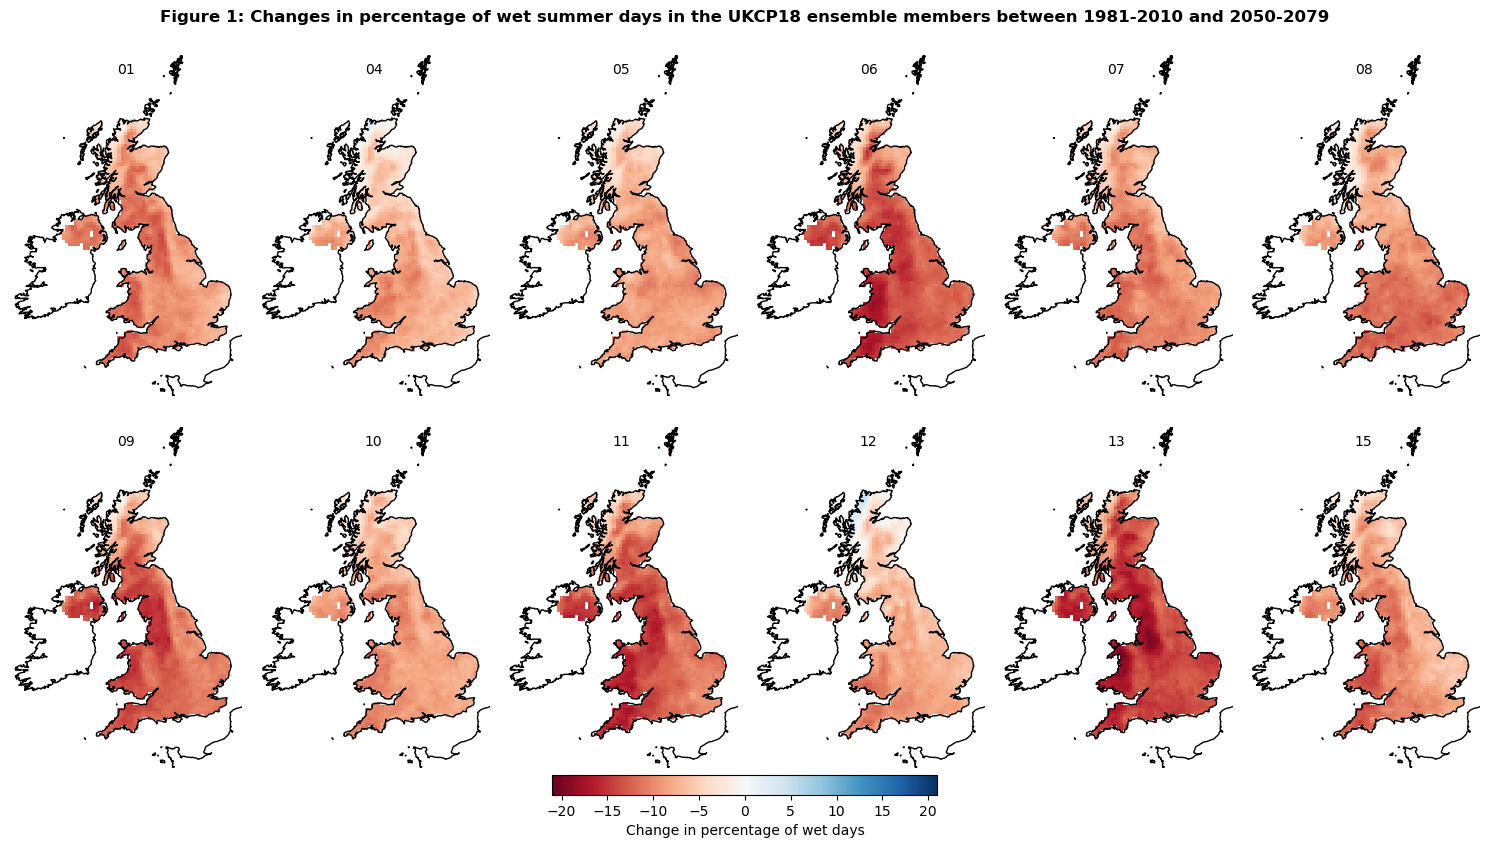

In [4]:
# load data
fwd = xr.open_dataset("fwd_JJA_2050-2079_ukcp18-12km.nc").fwd

# create array of subplots using OSGB projection, adjust spacing
fig, axs = plt.subplots(ncols = 6, nrows = 2, figsize = (15,8), sharex = True, sharey = True, dpi= 100, facecolor='w', edgecolor='k', subplot_kw = {"projection" : crs_osgb})
fig.tight_layout()
plt.subplots_adjust(hspace = 0)

# get extent of values for colourbar
vlim = np.ceil(max([np.abs(x) for x in [fwd.min(), fwd.max()]]))

# plot each ensemble member on separate axes
for i in range(12):
    
    ax = fig.axes[i]
    cbar = fwd.isel(run = i).plot(ax = ax, cmap = "RdBu", vmin = -vlim, vmax = vlim, add_colorbar = False)       # draw map
    
    ax.set_title(fwd.run.values[i], fontsize = "medium", y = 0.92)                                               # add title manually to customise height
    
    ax.set_extent((-2e5, 7e5, -1e5, 12.2e5), crs = crs_osgb)                                                     # fix plot extent to reduce whitespace
    ax.set_axis_off()                                                                                            # remove box around plot
    ax.coastlines()                                                                                              # draw coastlines
     
# add shared colourbar
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.025, pad = 0.01, label = "Change in percentage of wet days")

plt.suptitle("Figure 1: Changes in percentage of wet summer days in the UKCP18 ensemble members between 1981-2010 and 2050-2079", y = 1.0, fontweight = "bold")

<a id="simple-epps"></a>
#### **Simple EPP analysis for an ensemble with no hierarchical structure** [^](#top)

In [5]:
# load data
Y = xr.open_dataset("fwd_JJA_2050-2079_ukcp18-12km.nc").fwd

# centre the data by subtracting the ensemble mean at each location; flatten map array to vector
Ybar = Y.mean("run", skipna = False)
Y_tilde = (Y - Ybar).stack(s = ("projection_y_coordinate", "projection_x_coordinate")).dropna("s", "any").values

# compute EPPs on the centred data and plot
ukcp_epps = EPPs(Y_tilde, Ybar)
EPP_plot(*ukcp_epps.values(), cmap = "RdBu", markers = ["$"+str(i+1).rjust(2, "0")+"$" for i in range(12)], cbar_label = "Change in percentage of wet days")

plt.suptitle("Figure 2: EPPs analysis of the UKCP18 ensemble", y = 1.1, fontweight = "bold")

---
### **Analysis of an unbalanced structured ensemble** [^](#top)

The steps in the following analysis can be summarised as:  
&nbsp; (i) calculate least-squares estimates of the coefficients given by equation (3) in the paper;  
&nbsp; (ii) calculate the residual matrix $\textbf{e}^{(2)}$;  
&nbsp; (iii) calculate the EPPs of the coefficient matrices and, if appropriate, of $\textbf{e}^{(2)}$;  
&nbsp; (iv) use equation (10) in the paper to produce an estimated partitioning of total variation;  
&nbsp; (v) calculate the ranges of variation for the observed ensemble by carrying out Type I analyses based on Models 0, 1a, 1b and 2.

<a id="fitted-model2"></a>

#### **(i) Fit model 2 (including both GCM \& RCM effects)** [^](#top)

In [2]:
# Load the data
Y = xr.open_dataset("tasmax_JJA_1989-2008_EuroCORDEX.nc").tasmax

Ybar = Y.mean("run", skipna = False)
Y_tilde = (Y - Ybar).stack(s = ("projection_y_coordinate", "projection_x_coordinate")).dropna("s", "any").values      # centre data & flatten into vector
ens_sd = Y.std("run", skipna = False)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONSTRUCT DESIGN MATRICES

# identify GCM and RCM used for each run
run_names = Y.run.values
run_gcm = Y.run.str.replace("p1_.+","p1").values
run_rcm = Y.run.str.replace(".+_","").values

# get G and R, counts of unique GCMs and RCMs
gcms = sorted(set(run_gcm))
rcms = sorted(set(run_rcm))

n = len(run_names)
G = len(gcms)
R = len(rcms)

# create matrices indicating group membership & stack to form X
X_G = np.column_stack([[-1 if gcms[-1] in run_name else (1 if g in run_name else 0) for run_name in Y.run.values] for g in gcms[:-1]])
X_R = np.column_stack([[-1 if rcms[-1] in run_name else (1 if r in run_name else 0) for run_name in Y.run.values] for r in rcms[:-1]])
X = np.column_stack([np.ones([len(Y.run), 1]), X_G, X_R])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# FIT MODEL 2

# flatten data & solve equation (5) to find the fitted effects for model 2 (accounting for GCM and RCM simultaneously)
Y = Y.stack(s = ("projection_y_coordinate", "projection_x_coordinate")).dropna("s", "any").values
theta_hat = np.linalg.solve(X.transpose() @ X, X.transpose() @ Y)

# extract fitted effects for easier interpretation
mu_hat = theta_hat[0,:]
alpha_hat = np.row_stack([theta_hat[1:G,:], -theta_hat[1:G,:].sum(0)])
beta_hat = np.row_stack([theta_hat[G:,:], -theta_hat[G:,:].sum(0)])

<a id="model2-residuals"></a>

#### **(ii) Calculate the residual matrix** [^](#top)

In [3]:
# compute residuals
model2_res = Y - (X @ theta_hat)

<a id="gcm-epps"></a>

#### **(iii) Calculate EPPs of fitted GCM & RCM effects** [^](#top)



Text(0.5, 1.1, 'Figure 5: EPPs of fitted RCM effects')

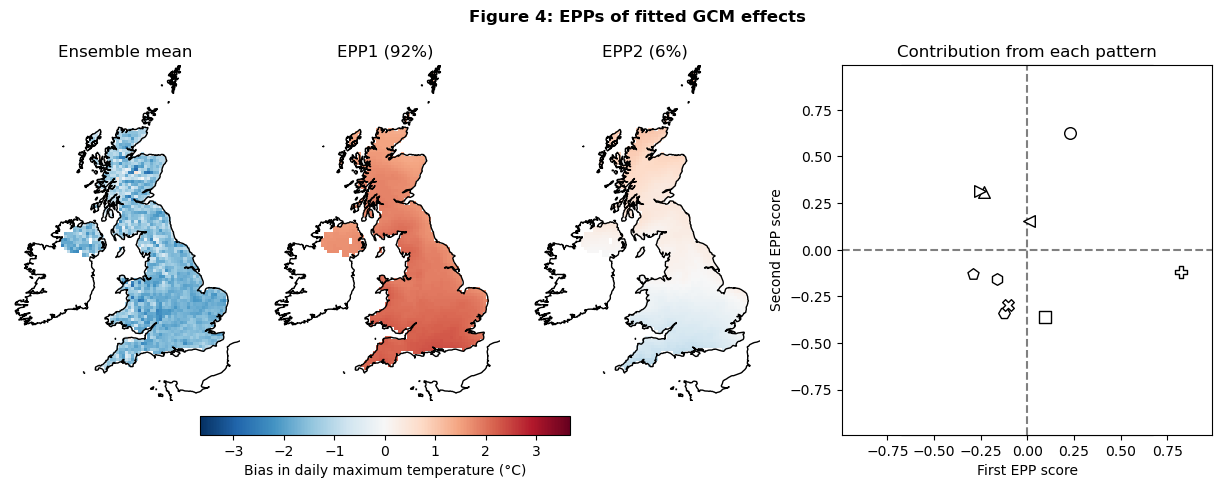

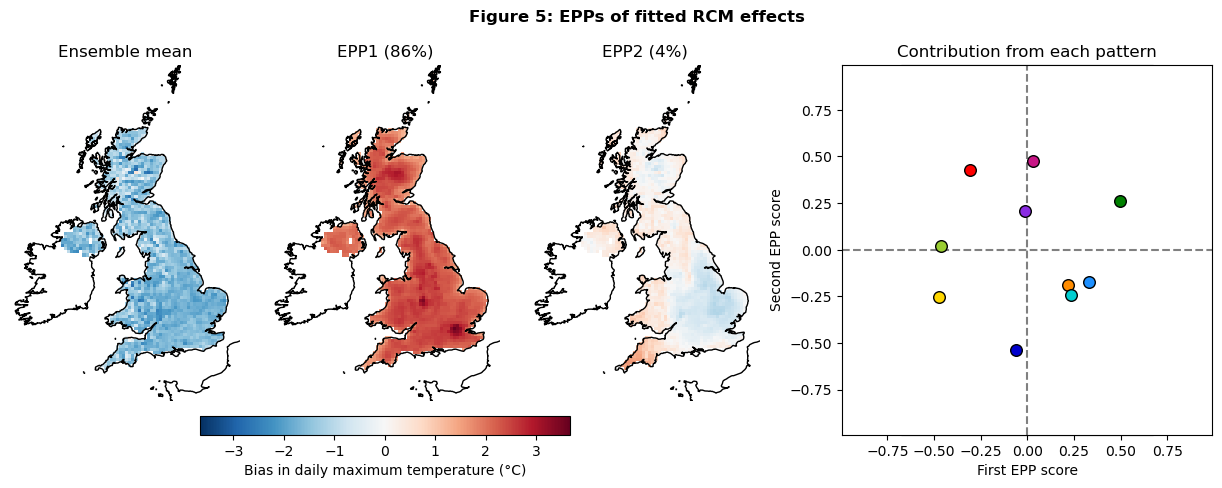

In [6]:
# compute EPPs from fitted effects
gcm_epps = EPPs(alpha_hat, Ybar)
rcm_epps = EPPs(beta_hat, Ybar)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# specify plotting symbols & colours to reflect those used in the paper
gcm_markers = {'CNRM-CERFACS-CNRM-CM5_r1i1p1': 'o', 'ICHEC-EC-EARTH_r12i1p1': 'p', 'ICHEC-EC-EARTH_r1i1p1': 'h', 'ICHEC-EC-EARTH_r3i1p1': 'H', 'IPSL-IPSL-CM5A-MR_r1i1p1': 's',
               'MOHC-HadGEM2-ES_r1i1p1': 'P', 'MPI-M-MPI-ESM-LR_r1i1p1': '<', 'MPI-M-MPI-ESM-LR_r2i1p1': '^', 'MPI-M-MPI-ESM-LR_r3i1p1': '>', 'NCC-NorESM1-M_r1i1p1': 'X'}

rcm_colours = {'ALADIN63': 'mediumblue', 'CCLM4-8-17': 'blueviolet', 'COSMO-crCLIM-v1-1': 'mediumvioletred', 'HIRHAM5': 'red', 'HadREM3-GA7-05': 'darkorange', 'RACMO22E': 'gold',
               'RCA4': 'yellowgreen', 'REMO2015': 'green', 'RegCM4-6': 'darkturquoise', 'WRF381P': 'dodgerblue'}

# get maximum values to fix colour scale & score axes for both GCMs and RCMs
vmax = max([np.abs(epps["EPPs"].max()) for epps in [gcm_epps, rcm_epps]] + [np.abs(epps["EPPs"].min()) for epps in [gcm_epps, rcm_epps]])
smax = max([np.abs(epps["scores"].max()) for epps in [gcm_epps, rcm_epps]] + [np.abs(epps["scores"].min()) for epps in [gcm_epps, rcm_epps]]) * 1.2

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# plots
EPP_plot(*gcm_epps.values(), cmap = "RdBu_r", markers = list(gcm_markers.values()), colours = "w", cbar_label = "Bias in daily maximum temperature (°C)", vlim = vmax)
plt.gca().set_xlim(-smax, smax); plt.gca().set_ylim(-smax, smax)
plt.suptitle("Figure 4: EPPs of fitted GCM effects", y = 1.1, fontweight = "bold")

EPP_plot(*rcm_epps.values(), cmap = "RdBu_r", colours = list(rcm_colours.values()), cbar_label = "Bias in daily maximum temperature (°C)", vlim = vmax)
plt.gca().set_xlim(-smax, smax); plt.gca().set_ylim(-smax, smax)
plt.suptitle("Figure 5: EPPs of fitted RCM effects", y = 1.1, fontweight = "bold")

<a id="residual-epps"></a>

##### **Calculate EPPs of residuals** [^](#top)



Text(0.5, 1.1, 'EPPs of residuals')

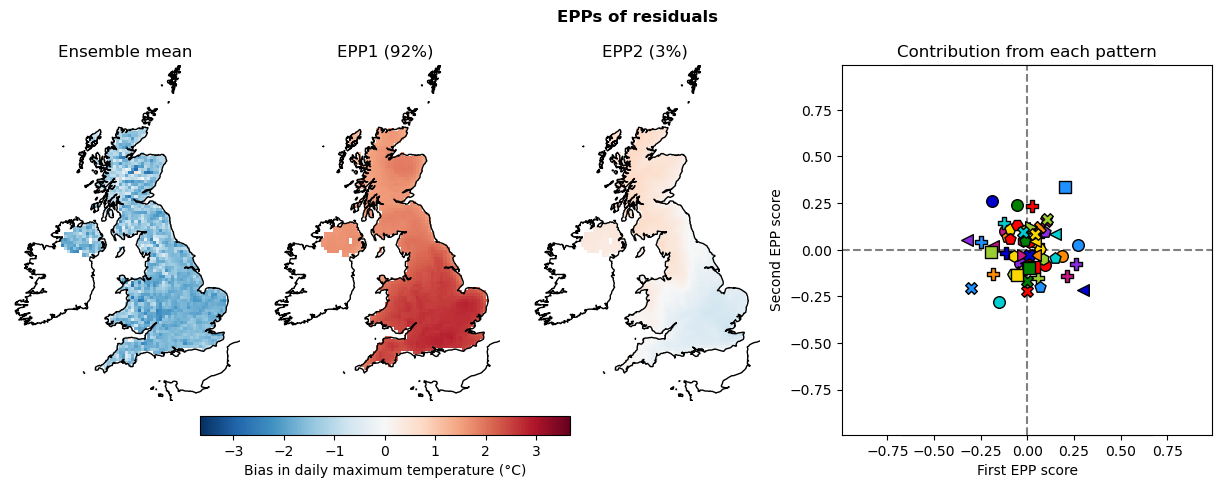

In [11]:
residual_epps = EPPs(model2_res, Ybar)
EPP_plot(*residual_epps.values(), cmap = "RdBu_r", cbar_label = "Bias in daily maximum temperature (°C)", vlim = vmax,
        markers = [gcm_markers[re.sub("p1_.+", "p1", g)] for g in run_names],
        colours = [rcm_colours[re.sub(".+p1_", "", r)] for r in run_names])

plt.gca().set_xlim(-smax, smax); plt.gca().set_ylim(-smax, smax)
plt.suptitle("EPPs of residuals", y = 1.1, fontweight = "bold")

<a id="estimated-anova"></a>

#### **(iv) Estimated partitioning of uncertainty** [^](#top)

In [14]:
# estimate 'complete' SSCPs using reweighted fitted effects & residuals
T_G2 = R * alpha_hat.transpose() @ alpha_hat
T_R2 = G * beta_hat.transpose() @ beta_hat
T_E2 = (R-1) * (G-1) * (model2_res.transpose() @ model2_res) / (n - R - G - 1)
T_2 = T_G2 + T_R2 + T_E2

# reshape all estimated SSCPs to maps
T_2, T_G2, T_R2, T_E2 = [reshape_to_map(np.diag(T), to_map = Ybar) for T in [T_2, T_G2, T_R2, T_E2]]

# get maps of contribution per grid cell & proportion of trace(T_2)
est_ve_maps = [T / T_2 * 100 for T in [T_G2, T_R2, T_E2]]
est_ve = ["\n("+str(int((T.sum() / T_2.sum() * 100).round().values))+"%)" for T in [T_G2, T_R2, T_E2]]

Text(0.5, 1.03, 'Figure 3: Estimated decomposition of variation in the EuroCORDEX ensemble')

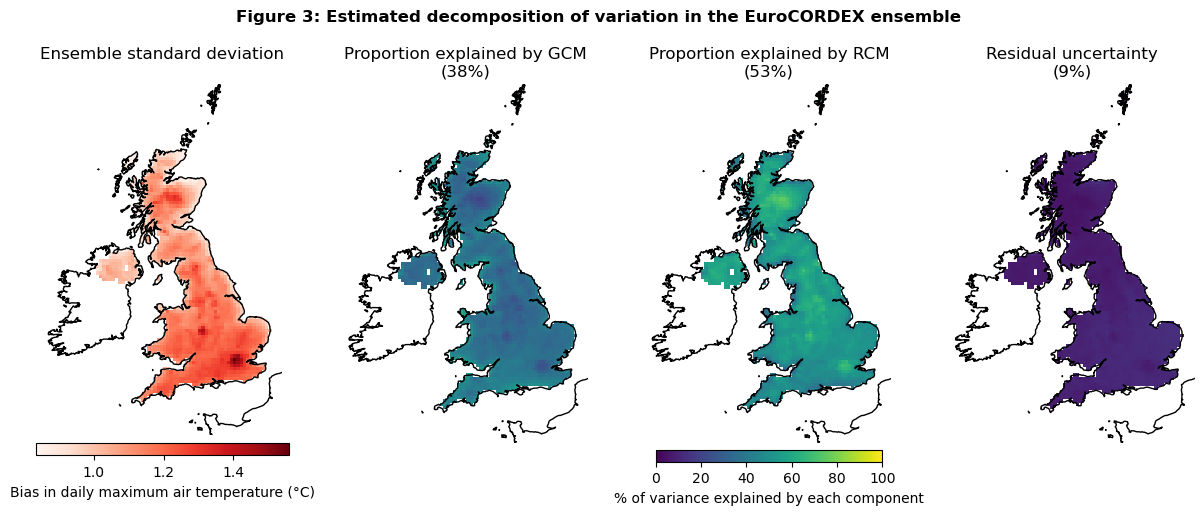

In [15]:
# create array of subplots using OSGB projection, adjust spacing
fig, axs = plt.subplots(ncols = 4, figsize = (15,5), sharex = True, sharey = True, dpi= 100, facecolor='w', edgecolor='k', subplot_kw = {"projection" : crs_osgb})
plt.subplots_adjust(hspace = 0)

# set spatial extent of map axes, remove bounding box, add coastlines
for ax in fig.axes:
    ax.set_extent((-2e5, 7e5, -1e5, 12.2e5), crs = crs_osgb)                                                       # fix plot extent to reduce whitespace
    ax.set_axis_off()                                                                                              # remove box around plot
    ax.coastlines()                                                                                                # draw coastlines
    
cbar_ss = ens_sd.plot(ax = axs[0], cmap = "Reds", add_colorbar = False)
axs[0].set_title("Ensemble standard deviation\n")
    
for i in range(3):
    cbar_ve = est_ve_maps[i].plot(ax = axs[i+1], vmin = 0, vmax = 100, add_colorbar = False, cmap = "viridis")
    titlestring = ["Proportion explained by GCM", "Proportion explained by RCM", "Residual uncertainty"][i] + est_ve[i]
    axs[i+1].set_title(titlestring)

plt.colorbar(cbar_ss, ax = axs[0], location = "bottom", pad = 0.02, fraction = 0.05, label ="Bias in daily maximum air temperature (°C)")
plt.colorbar(cbar_ve, ax = axs[1:], location = "bottom", pad = 0.02, fraction = 0.03, label = "% of variance explained by each component")

plt.suptitle("Figure 3: Estimated decomposition of variation in the EuroCORDEX ensemble", y = 1.03, fontweight = "bold")